In this notebook, I used top 100 ranked hotels, filtered out avg nightly rate outliers, and used hotel names, fitted a classic LogReg model then predict_prob.

In [131]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [196]:
df1 = pd.read_csv('2878240_2020_02_13.csv')
df2 = pd.read_csv('2878258_2020_02_13.csv')

df1['checkin_date'] = pd.to_datetime(df1['checkin_date'])
df1['checkout_date'] = pd.to_datetime(df1['checkout_date'])
df2['checkin_date'] = pd.to_datetime(df2['checkin_date'])
df2['checkout_date'] = pd.to_datetime(df2['checkout_date'])
df1.sort_values(by=['checkin_date'], inplace=True)
df2.sort_values(by=['checkin_date'], inplace=True)
frames = [df1, df2]
df = pd.concat(frames)

df = df.drop_duplicates(keep='first')
df['length_of_stay'] = (df['checkout_date'] - df['checkin_date']).dt.days
df['avg_nightly_rate'] = df['total_price'] / df['num_of_rooms'] / df['length_of_stay']

df = df.loc[df['rank'] <= 100]
df1 = df[['searchid', 'purchased', 'rank', 'avg_nightly_rate', 'hotel_name']]
P = np.percentile(df1['avg_nightly_rate'], [5, 95])
df1 = df1[(df1['avg_nightly_rate'] > P[0]) & (df1['avg_nightly_rate'] < P[1])]

In [197]:
df1.head()

,searchid,purchased,rank,avg_nightly_rate,hotel_name
24425,7AB1B34B-3901-47FE-B4DF-0A5F3FC16164,False,49,247.0,Grand Hotel& Suites Toronto
24424,7AB1B34B-3901-47FE-B4DF-0A5F3FC16164,False,48,239.0,Toronto Marriott City Centre Hotel
24423,7AB1B34B-3901-47FE-B4DF-0A5F3FC16164,False,47,216.0,The York Boutique Suites
24422,7AB1B34B-3901-47FE-B4DF-0A5F3FC16164,False,46,204.0,Aaira Suites
24421,7AB1B34B-3901-47FE-B4DF-0A5F3FC16164,False,45,189.0,Simply Comfort. Gorgeous Apartments in the Hea...


In [198]:
df1['purchased'].value_counts() / df1.shape[0]

False    0.986439
True     0.013561
Name: purchased, dtype: float64

Avg nightly rate seems to have a little bit negative effect on purchase, rank does not seem to have effect on purchase.

In [134]:
df1.groupby('purchased').mean()

,rank,avg_nightly_rate
purchased,,
False,46.497938,304.596275
True,47.812500,282.140774


Look at the hotels that have the highest avg purchase rate, none of them were positioned within top 20, and their prices were somewhere in between around 200 dollars and 500 dollars.

In [135]:
df1.groupby('hotel_name').mean().sort_values('purchased', ascending=False).head(20)

,purchased,rank,avg_nightly_rate
hotel_name,,,
Luxury Penthouse In Downtown Toronto,0.250000,70.250000,548.607143
iResidence in Toronto- Vacation Home,0.166667,85.500000,390.314815
Elegant condo with stunning lake & views,0.111111,51.777778,263.000000
Livingsuites Toronto - Front & John,0.111111,27.555556,199.388889
QuickStay - Style in Yorkville (Yonge & Bloor),0.071429,87.357143,202.982143
Stunning Suites - Beautiful 2bdr Condo,0.064516,57.451613,347.912442
Galaxy Suites - Iceboat Toronto,0.062500,68.031250,204.269271
Rooms in Downtown Heritage House,0.058824,71.764706,177.558824
Sky Suites Yorkville,0.055556,78.277778,425.287478


According to the above, the number 1 purchased hotel is "Luxury Penthouse In Downtown Toronto". The reason is that this hotel was booked once after only 4 searches. We run into the same problems that described in Wayfair paper, that is, if we just simply compare purchase rate between two properties, we will run into assumption that “Luxury Penthouse In Downtown Toronto” is the highest purchased hotel, while in fact, "Luxury Penthouse In Downtown Toronto" just got lucky.

In [121]:
df1.loc[df1['hotel_name'] == 'Luxury Penthouse In Downtown Toronto']['purchased'].value_counts()

False    3
True     1
Name: purchased, dtype: int64

In [123]:
df1.loc[df1['hotel_name'] == 'QuickStay - Gorgeous 2-Bedroom in the Heart of Downtown']['purchased'].value_counts()

False    42
True      2
Name: purchased, dtype: int64

An illustration of the power of position effects for the above 20 hotels - no effect.

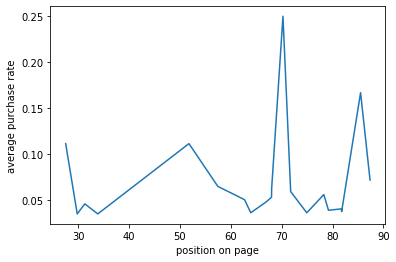

In [124]:
sns.lineplot(x="rank", y="purchased", data=df1.groupby('hotel_name').mean().sort_values('purchased', ascending=False).head(20))
plt.xlabel('position on page')
plt.ylabel('average purchase rate');

I was expecting something like "purchase rate goes down when position goes down". Note, the position number higher means goes down on the page. In another word, if this hotel is positioned down on the page, it will likely to sell less. This is not the case here.

In [137]:
df_new = df1.groupby('hotel_name').mean().sort_values('purchased', ascending=False)
df_new.reset_index(inplace=True)
df_new.loc[df_new['hotel_name'].str.contains('Hotel'), 'category'] = 'hotel'

In [155]:
df_new.to_csv('df_new.csv', encoding='utf-8', index=False)

In [166]:
df_new = pd.read_csv('df_new.csv')

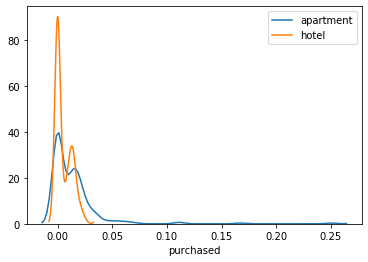

In [177]:
sns.distplot(df_new.loc[df_new['category'] == 'apartment']['purchased'], hist=False, label='apartment')
sns.distplot(df_new.loc[df_new['category'] == 'hotel']['purchased'], hist=False, label='hotel')
plt.legend()
#plt.xlim(0,0.10);

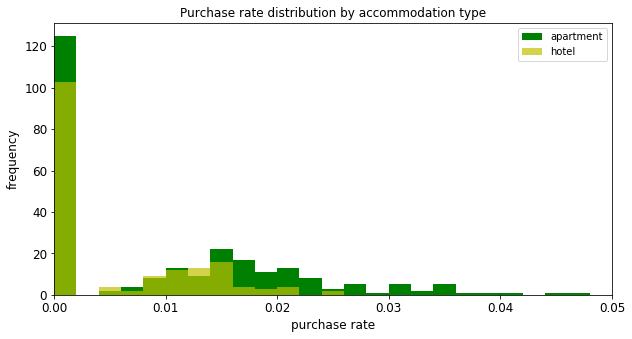

In [203]:
apt = df_new.loc[df_new['category'] == 'apartment', 'purchased']
hotel = df_new.loc[df_new['category'] == 'hotel', 'purchased']
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(apt, color='g', alpha=1.0, bins=100, range = [0, 0.20],
       label='apartment')
ax.hist(hotel, color='y', alpha=0.7, bins=100, range = [0, 0.20],
       label='hotel')
plt.xlabel('purchase rate', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Purchase rate distribution by accommodation type')
plt.tick_params(labelsize=12)
plt.xlim(0, 0.050)
plt.legend()
plt.show();

The average purchase rate for apartment is 0.013 (1.3%), the average purchase rate for hotel is 0.005 (0.5%). This means an apartment suite is more than twice likely to be purchased, vs. a hotel room, in Toronto.

In [172]:
df_new.loc[df_new['category'] == 'apartment']['purchased'].describe()

count    269.000000
mean       0.013220
std        0.023584
min        0.000000
25%        0.000000
50%        0.009302
75%        0.018519
max        0.250000
Name: purchased, dtype: float64

In [173]:
df_new.loc[df_new['category'] == 'hotel']['purchased'].describe()

count    172.000000
mean       0.005266
std        0.007014
min        0.000000
25%        0.000000
50%        0.000000
75%        0.011809
max        0.024590
Name: purchased, dtype: float64

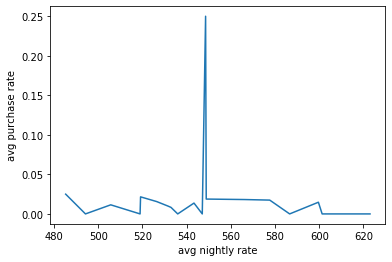

In [130]:
sns.lineplot(x="avg_nightly_rate", y="purchased", data=df1.groupby('hotel_name').mean().sort_values('avg_nightly_rate', ascending=False).head(20))
plt.xlabel('avg nightly rate')
plt.ylabel('avg purchase rate');

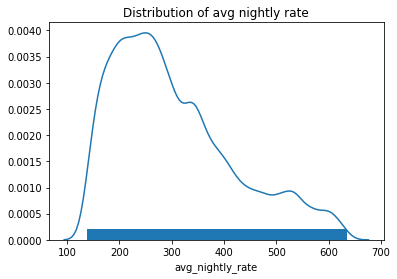

In [87]:
sns.distplot(df1['avg_nightly_rate'], rug=True, hist=False)
plt.title('Distribution of avg nightly rate');

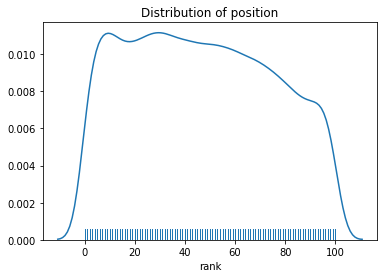

In [88]:
sns.distplot(df1['rank'], rug=True, hist=False)
plt.title('Distribution of position');

Fit a classic logistic regression model.

In [89]:
df1 = pd.get_dummies(df1, columns=['hotel_name'])
X = df1.drop('purchased', axis=1)
y = df1.purchased
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state = 0)

In [90]:
df_result = X_test.copy()

In [91]:
X_train.drop('searchid', axis=1, inplace=True)
X_test.drop('searchid', axis=1, inplace=True)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
logReg = LogisticRegression().fit(X_train, y_train)

Probability estimates, for the True class.

In [92]:
df_result['probability'] = logReg.predict_proba(X_test)[:,1]

Re-construct dummies back to hotel name variable. 

In [95]:
x = df_result.ix[:, 3:444].stack()
x = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))
x = pd.DataFrame({'hotel_name':x.values})
x['hotel_name'] = x['hotel_name'].map(lambda x: x.lstrip('hotel_name_'))

In [96]:
df_result = df_result[['searchid', 'rank', 'avg_nightly_rate', 'probability']].reset_index()
df_result.drop('index', axis=1, inplace=True)

Sort probabilities for the test set.

In [108]:
df_result.merge(x, left_index=True, right_index=True).sort_values('probability', ascending=False).head(20)

,searchid,rank,avg_nightly_rate,probability,hotel_name
9521,3BCF0DC0-A00B-4A29-B962-D7A6CD955396,25,179.500000,0.057441,Livingsuites Toronto - Front & John
2260,623199FE-640A-43D5-8A14-240717026444,25,179.500000,0.057441,Livingsuites Toronto - Front & John
11853,7AE84D0F-B3E8-4065-9978-2883B1EA61D2,25,192.000000,0.055300,Livingsuites Toronto - Front & John
2982,1B9149FC-53AF-47DC-997F-A13A9A8A6326,22,209.333333,0.052189,Livingsuites Toronto - Front & John
10310,7BEC0985-CBA9-447C-AA6B-288D6965B351,27,163.250000,0.045482,QuickStay - Gorgeous 2-Bedroom in the Heart of...
7703,DEBC69E0-DC75-4340-9058-9565FD7731E5,39,208.666667,0.044252,Sarkar Suites - Blue Jays Way
4552,1E908602-1831-4CF0-B3FA-9F782628957C,29,149.000000,0.043888,Sarkar Suites - Maple Leaf Square
937,201102BC-849B-4A4B-8D8F-02A603B08EDA,47,227.000000,0.042400,Sarkar Suites - Blue Jays Way
2338,509C50E0-A72B-45FA-9997-CEA757D83996,57,241.500000,0.042154,CN Tower View Design apart 3BD-2BA DT
384,2A39CF6E-8B8A-46FD-8BBA-D135E5B2F03B,23,160.666667,0.041904,Sarkar Suites - Maple Leaf Square


It seems that PC users come to PC website, when come to book hotels, they know what they want and it does not take them long to make decision, and they make relative quick decisions on hotel bookings, and most likely these bookings are toward condo or appartment suits. 

What does it mean when we say "a very good hotel"? It depends. For many of us, Hilton Toronto is a very good hotel and I would be happy to see it on the top position of the page. But if most of PC customers are interested in apartment suites, they don't need to be persuaded and they know (more or less) on what they want. So, why not position apartment suites on the top positions of the page?